<br>
<br>
<br>
<!DOCTYPE html>
<html>

<br>

<center><font size="6"><b>Predictive Text Generator</b></font></center>
</body>
</html>

<br>
<br>


<!--
### Problem statement

* Use any book you like from https://www.gutenberg.org/ as a dataset
* Create a predictive text generator trained on the dataset you choose.
* Clean and explore the dataset. Report your findings.
* Use various models and compare them on speed and accuracy/human readability.
* Report your findings. (Basic RNNS, LSTMs, Transformers etc)
* Use TF serving to deploy the model as an API (on local)
*  Build a TF serving client to interact with the API.
-->


### Importing ,Cleaning and exploring the dataset

##### Book/dataset choosed for this project is



> [**The Adventures of Sherlock Holmes**](https://www.gutenberg.org/files/1661/1661-0.txt)
<br>
-*by Arthur Conan Doyle*




In [1]:
sherlock_holmes='https://www.gutenberg.org/files/1661/1661-0.txt'

In [2]:
from urllib.request import urlopen
book = urlopen(sherlock_holmes).read().decode('utf-8') #utf-8 format
print(book[:700])


﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes, by Arthur Conan Doyle

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: The Adventures of Sherlock Holmes

Author: Arthur Conan Doyle

Release Date: November 29, 2002 [eBook #1661]
[Most recently updated: May 20, 201


##### importing all the required libraries


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
import random
import os
import time

In [4]:
words=book.split()

In [ ]:
#! pip install matplotlib --upgrade -q

##### Exploring the dataset

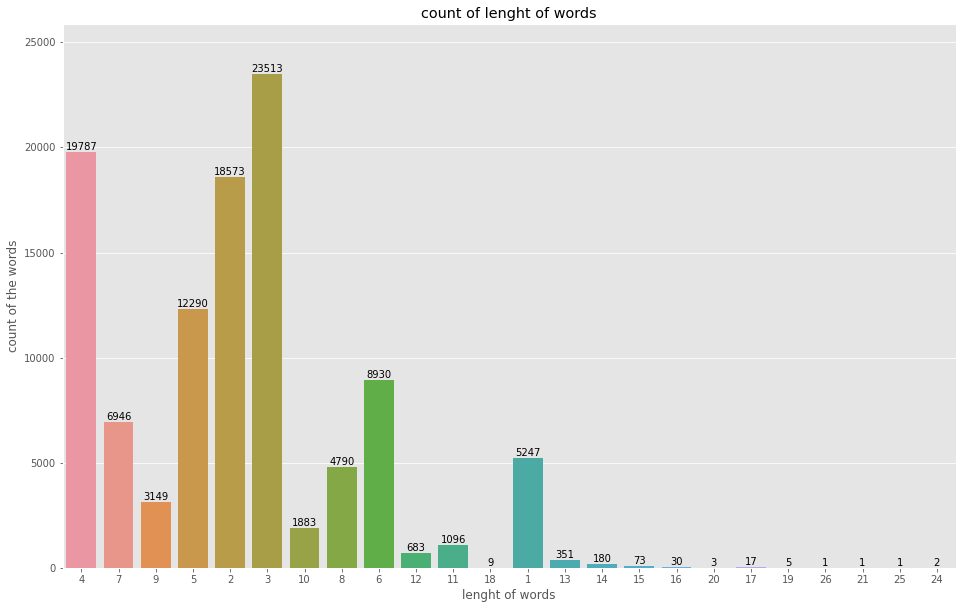

In [ ]:
counter_dict = {}

for word in words:
  counter_dict[str(len(word))] = 0
for word in words:
  counter_dict[str(len(word))] +=1

 

# plot data
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=list(counter_dict.keys()), y=list(counter_dict.values()), ax=ax)
plt.xlabel("lenght of words")
plt.ylabel("count of the words")
plt.title("count of lenght of words")

# annotate
ax.bar_label(ax.containers[0], label_type='edge')

# pad the spacing between the number and the edge of the figure
ax.margins(y=0.1)




In [ ]:
random.sample(words, 10)

['not',
 'And',
 'a',
 'struck,',
 'I',
 'unnatural',
 'my',
 'would',
 'parents',
 'so']

##### Python's `Counter` object to count the most common letters in the first of these texts:


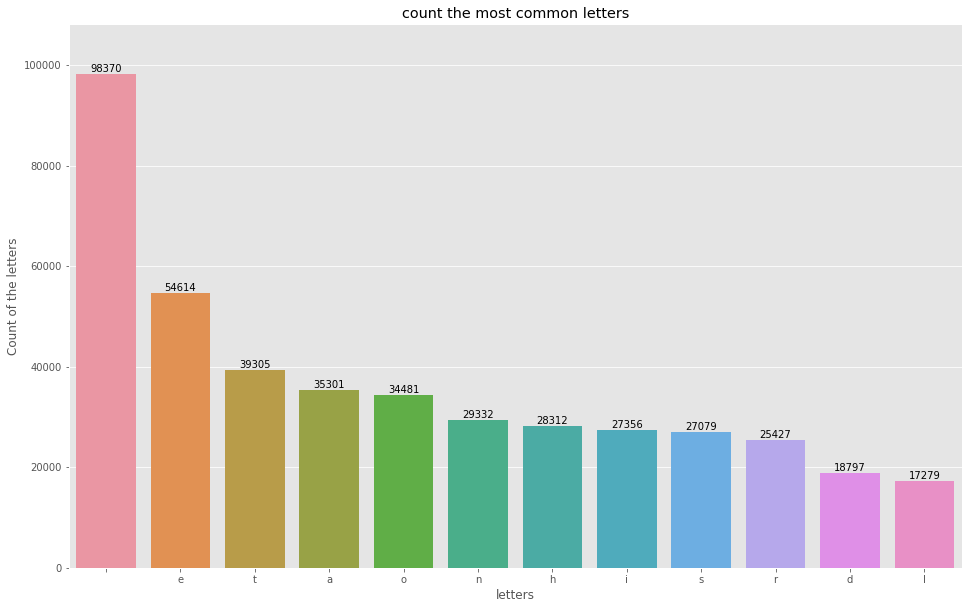

In [ ]:
from matplotlib import pyplot as plt
from collections import Counter
l=Counter(book).most_common(12)

ind = []
fre = []
for item in l:
   ind.append(item[0])
   fre.append(item[1])
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=ind, y=fre, ax=ax)
plt.xlabel("letters")
plt.ylabel("Count of the letters")
plt.title("count the most common letters")

ax.bar_label(ax.containers[0], label_type='edge')

ax.margins(y=0.1)

##### Specifying the `words` variable gives the most frequent words instead:

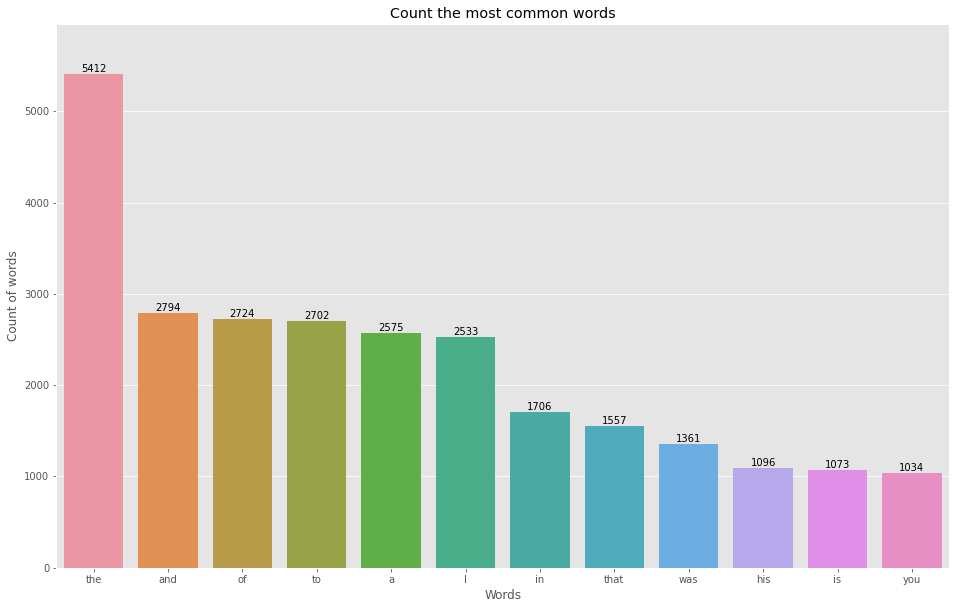

In [ ]:
l= Counter(words).most_common(12)

ind = []
fre = []
for item in l:
   ind.append(item[0])
   fre.append(item[1])
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=ind, y=fre, ax=ax)
plt.xlabel("Words")
plt.ylabel("Count of words")
plt.title("Count the most common words")

ax.bar_label(ax.containers[0], label_type='edge')

ax.margins(y=0.1)

##### Wordcloud

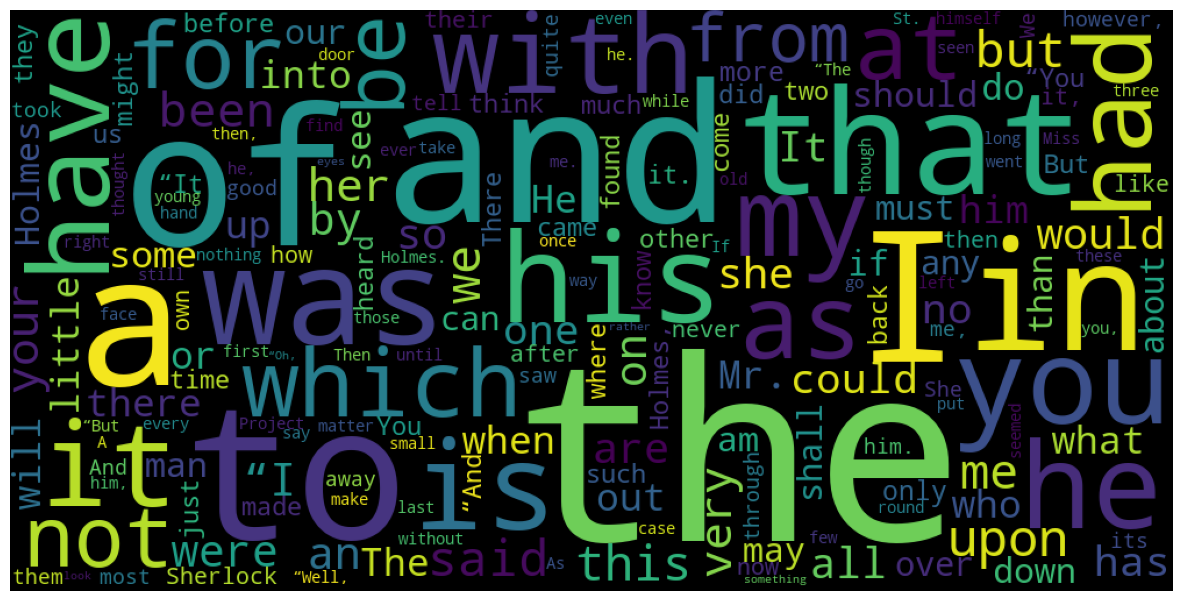

In [ ]:
from matplotlib import pyplot as plt
plt.style.use("default")
from collections import Counter
l= dict(Counter(words))
import matplotlib.pyplot as plt
from wordcloud import WordCloud



wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(l)

plt.figure(figsize=(15,8))
plt.grid(False)
plt.axis('off')

plt.imshow(wordcloud)

### Data Cleaning 

##### 1. Removing useless noise

* Here we can see extra noise which is useless for our model 
i,e., about the project gutenberg, License etc which is at the start and end of the book(.txt)


* From observation we can conclude that the data which is required for training:





1.  Starts at : `'I. A SCANDAL IN BOHEMIA'`



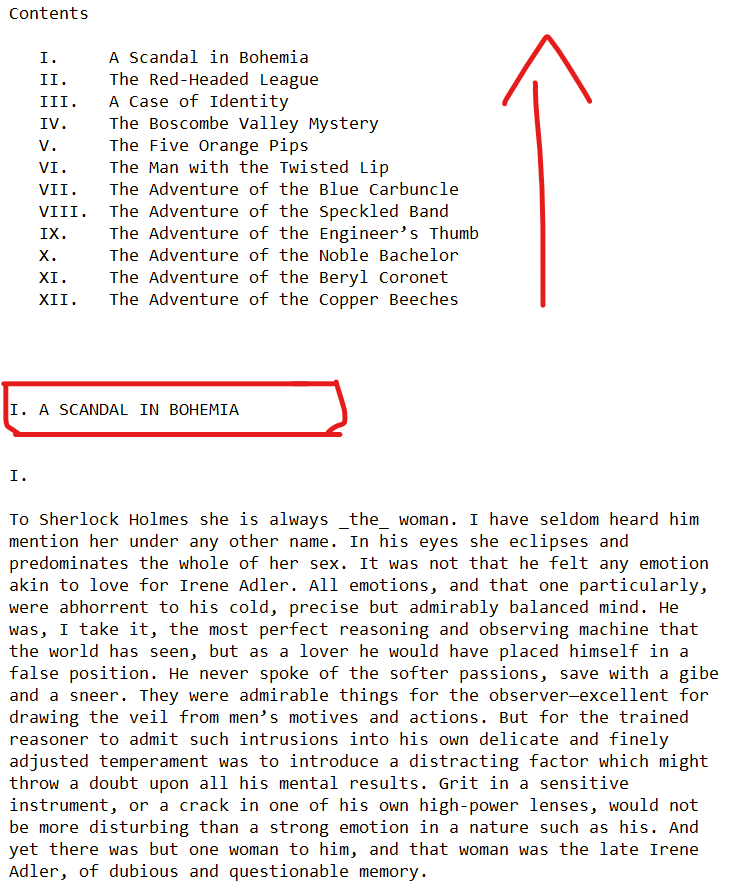

 <br>
 <br>
 
  2. Ends at : `'*** END OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***'`



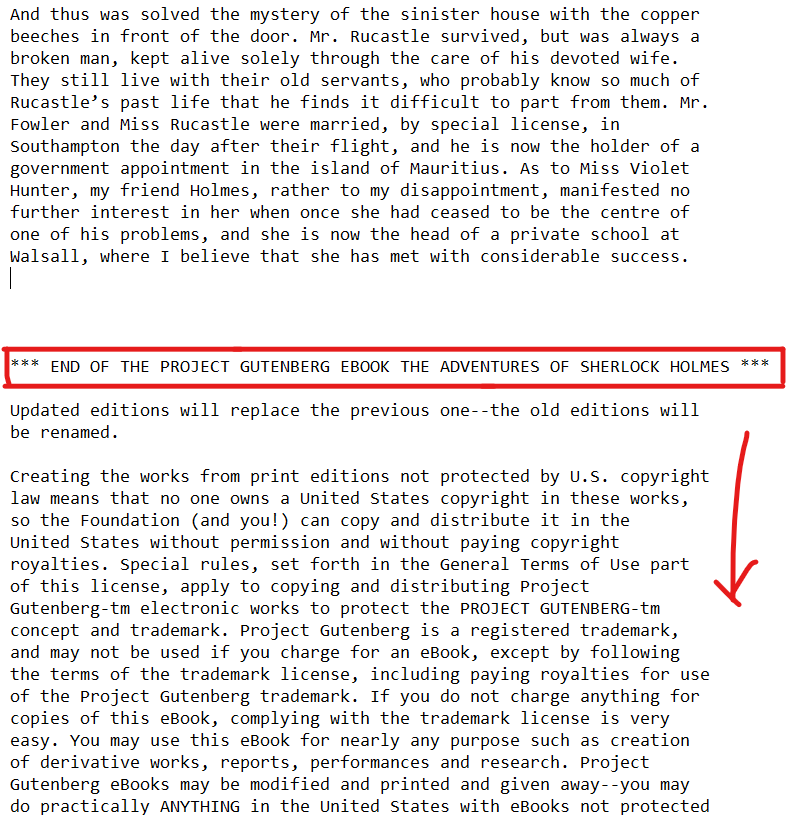

##### removing that useless data

In [5]:
start=book.index('I. A SCANDAL IN BOHEMIA')-1
end=book.index('*** END OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***')

In [6]:
book=book[start:end]

##### We are identifying unique characters in our data before clearning

In [7]:
vocab = sorted(set(book))

print('Total Unique characters :',len(vocab))
print('List of total unique characters : '+str(vocab))

Total Unique characters : 89
List of total unique characters : ['\n', '\r', ' ', '!', '&', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', '½', 'à', 'â', 'æ', 'è', 'é', 'œ', '—', '‘', '’', '“', '”']


##### 2. Here we can see that the characters with similar 


Bad characters

*  `'_', 'à', 'â', 'æ', 'è', 'é', 'œ', '—'`

we can replace this with best character 
*  ```
  '_' as ' '
  'à' as 'a'
  'â' as 'a'
  'æ' as 'e'
  'è' as 'e'
  'é' as 'e'
  'œ' as 'oe'
  '—' as ' '
  ```



In [8]:
bad_chars = ['_','à', 'â', 'æ', 'è', 'é', 'œ','—']
replace_char=[' ','a','a','e','e','e','oe',' ']
for i in range(len(bad_chars)):
    book = book.replace(bad_chars[i],replace_char[i])

##### We are identifying unique characters in our data after clearning
##### Extract the vocabulary

In [9]:
vocabulary = sorted(set(book))

print('Total Unique characters :',len(vocabulary))
print(vocabulary)

Total Unique characters : 81
['\n', '\r', ' ', '!', '&', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', '½', '‘', '’', '“', '”']


### Data preprocessing

##### Create 'character to index'/ 'index to character' dictionaries and convert the text

In [10]:
#creading a list of range of total characters
length_of_voc=[i for i in range(81)]
print(length_of_voc)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


##### creating vocabulary/characters to index

In [11]:
vocab_2_index = {i:j for i,j in zip(vocabulary,length_of_voc)}
print(vocab_2_index)

{'\n': 0, '\r': 1, ' ': 2, '!': 3, '&': 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '4': 14, '5': 15, '6': 16, '7': 17, '8': 18, '9': 19, ':': 20, ';': 21, '?': 22, 'A': 23, 'B': 24, 'C': 25, 'D': 26, 'E': 27, 'F': 28, 'G': 29, 'H': 30, 'I': 31, 'J': 32, 'K': 33, 'L': 34, 'M': 35, 'N': 36, 'O': 37, 'P': 38, 'Q': 39, 'R': 40, 'S': 41, 'T': 42, 'U': 43, 'V': 44, 'W': 45, 'X': 46, 'Y': 47, 'Z': 48, 'a': 49, 'b': 50, 'c': 51, 'd': 52, 'e': 53, 'f': 54, 'g': 55, 'h': 56, 'i': 57, 'j': 58, 'k': 59, 'l': 60, 'm': 61, 'n': 62, 'o': 63, 'p': 64, 'q': 65, 'r': 66, 's': 67, 't': 68, 'u': 69, 'v': 70, 'w': 71, 'x': 72, 'y': 73, 'z': 74, '£': 75, '½': 76, '‘': 77, '’': 78, '“': 79, '”': 80}


##### creating index to charcter

In [12]:
index_2_vocab = {i:j for j,i in zip(vocabulary,length_of_voc)}
print(index_2_vocab)
index_2_vocab_arr=np.array(vocabulary)

{0: '\n', 1: '\r', 2: ' ', 3: '!', 4: '&', 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: '0', 11: '1', 12: '2', 13: '3', 14: '4', 15: '5', 16: '6', 17: '7', 18: '8', 19: '9', 20: ':', 21: ';', 22: '?', 23: 'A', 24: 'B', 25: 'C', 26: 'D', 27: 'E', 28: 'F', 29: 'G', 30: 'H', 31: 'I', 32: 'J', 33: 'K', 34: 'L', 35: 'M', 36: 'N', 37: 'O', 38: 'P', 39: 'Q', 40: 'R', 41: 'S', 42: 'T', 43: 'U', 44: 'V', 45: 'W', 46: 'X', 47: 'Y', 48: 'Z', 49: 'a', 50: 'b', 51: 'c', 52: 'd', 53: 'e', 54: 'f', 55: 'g', 56: 'h', 57: 'i', 58: 'j', 59: 'k', 60: 'l', 61: 'm', 62: 'n', 63: 'o', 64: 'p', 65: 'q', 66: 'r', 67: 's', 68: 't', 69: 'u', 70: 'v', 71: 'w', 72: 'x', 73: 'y', 74: 'z', 75: '£', 76: '½', 77: '‘', 78: '’', 79: '“', 80: '”'}


##### checking the embedding for the book/text(The Adventures of Sherlock Holmes)

In [13]:
text_2_indexs =np.array([vocab_2_index[i] for i in book])

print("Data before embedding : ")
print(book[:400],"\n")
print("Data after embedding : ")
print(text_2_indexs[:400])

Data before embedding : 

I. A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always  the  woman. I have seldom heard him
mention her under any other name. In his eyes she eclipses and
predominates the whole of her sex. It was not that he felt any emotion
akin to love for Irene Adler. All emotions, and that one particularly,
were abhorrent to his cold, precise but admirably balanced mind. He
was, I take it,  

Data after embedding : 
[ 0 31  9  2 23  2 41 25 23 36 26 23 34  2 31 36  2 24 37 30 27 35 31 23
  1  0  1  0  1  0 31  9  1  0  1  0 42 63  2 41 56 53 66 60 63 51 59  2
 30 63 60 61 53 67  2 67 56 53  2 57 67  2 49 60 71 49 73 67  2  2 68 56
 53  2  2 71 63 61 49 62  9  2 31  2 56 49 70 53  2 67 53 60 52 63 61  2
 56 53 49 66 52  2 56 57 61  1  0 61 53 62 68 57 63 62  2 56 53 66  2 69
 62 52 53 66  2 49 62 73  2 63 68 56 53 66  2 62 49 61 53  9  2 31 62  2
 56 57 67  2 53 73 53 67  2 67 56 53  2 53 51 60 57 64 67 53 67  2 49 62
 52  1  0 64 66 53 52 63 61 57 62 49 68 53 67  

### Prepare TF data pipeline

##### Creating the input and output dataset for training the sequential models

##### We set the sequences length to 150+1 size.
##### So we will predict every character based on previous 150 chars.

In [14]:
input_length = 150

##### We are slicing the numeric array created with indexes of charcters present in the dataset

In [15]:
model_dataset_train = tf.data.Dataset.from_tensor_slices(text_2_indexs) 

##### We created sequences of 150+1 from dataset

In [16]:
Model_train = model_dataset_train.batch(input_length+1, drop_remainder=True)
for i in Model_train.take(1):
  print(i)

tf.Tensor(
[ 0 31  9  2 23  2 41 25 23 36 26 23 34  2 31 36  2 24 37 30 27 35 31 23
  1  0  1  0  1  0 31  9  1  0  1  0 42 63  2 41 56 53 66 60 63 51 59  2
 30 63 60 61 53 67  2 67 56 53  2 57 67  2 49 60 71 49 73 67  2  2 68 56
 53  2  2 71 63 61 49 62  9  2 31  2 56 49 70 53  2 67 53 60 52 63 61  2
 56 53 49 66 52  2 56 57 61  1  0 61 53 62 68 57 63 62  2 56 53 66  2 69
 62 52 53 66  2 49 62 73  2 63 68 56 53 66  2 62 49 61 53  9  2 31 62  2
 56 57 67  2 53 73 53], shape=(151,), dtype=int64)


##### We are splitting our dataset into input part and target part
##### Basically creating x and y.

In [17]:
def dataset_split(text):
  inputx = text[:-1]
  outputx = text[1:]
  return inputx, outputx
train_dataset = Model_train.map(dataset_split)

##### Dataset size after spliting

In [18]:
print('dataset size: ', len(list(train_dataset.as_numpy_iterator())))

dataset size:  3798


##### input and output of the dataset

In [19]:
for input, output in  train_dataset.take(1):
  print('Input data: ', repr(''.join(index_2_vocab_arr[input.numpy()])))
  print('Target data:', repr(''.join(index_2_vocab_arr[output.numpy()])))

Input data:  '\nI. A SCANDAL IN BOHEMIA\r\n\r\n\r\nI.\r\n\r\nTo Sherlock Holmes she is always  the  woman. I have seldom heard him\r\nmention her under any other name. In his ey'
Target data: 'I. A SCANDAL IN BOHEMIA\r\n\r\n\r\nI.\r\n\r\nTo Sherlock Holmes she is always  the  woman. I have seldom heard him\r\nmention her under any other name. In his eye'


In [20]:
BATCH_SIZE = 64 # Batch size
vocab_size = len(vocabulary)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

##### Text generation for RNN, LSTM

In [21]:
def generate_text(model, start_string, num_generate, temperature):
  start = time.time()
  #Converting the input string to vector

  input_eval = [vocab_2_index[s] for s in start_string]
  #Converting into required tensor dimension
  input_eval = tf.expand_dims(input_eval, 0) 
  #Empty string to store the predictions
  text_generated = [] 
  # Clears the hidden states in the RNN
  model.reset_states() 

  for i in range(num_generate): 
    # prediction for single character
    predictions = model(input_eval) 
    predictions = tf.squeeze(predictions, 0) 
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    #Here we are taking the predicted char as the next input to the model
    input_eval = tf.expand_dims([predicted_id], 0) 
    # Also devectorize the number and add to the generated text
    text_generated.append(index_2_vocab_arr[predicted_id]) 
  end = time.time()

  global time_taken
  time_taken = end-start

  print(start_string + ''.join(text_generated))
  print('\n\nRun time took by this model:', time_taken)

<br>
<br>
<br>

### **RNN Model**

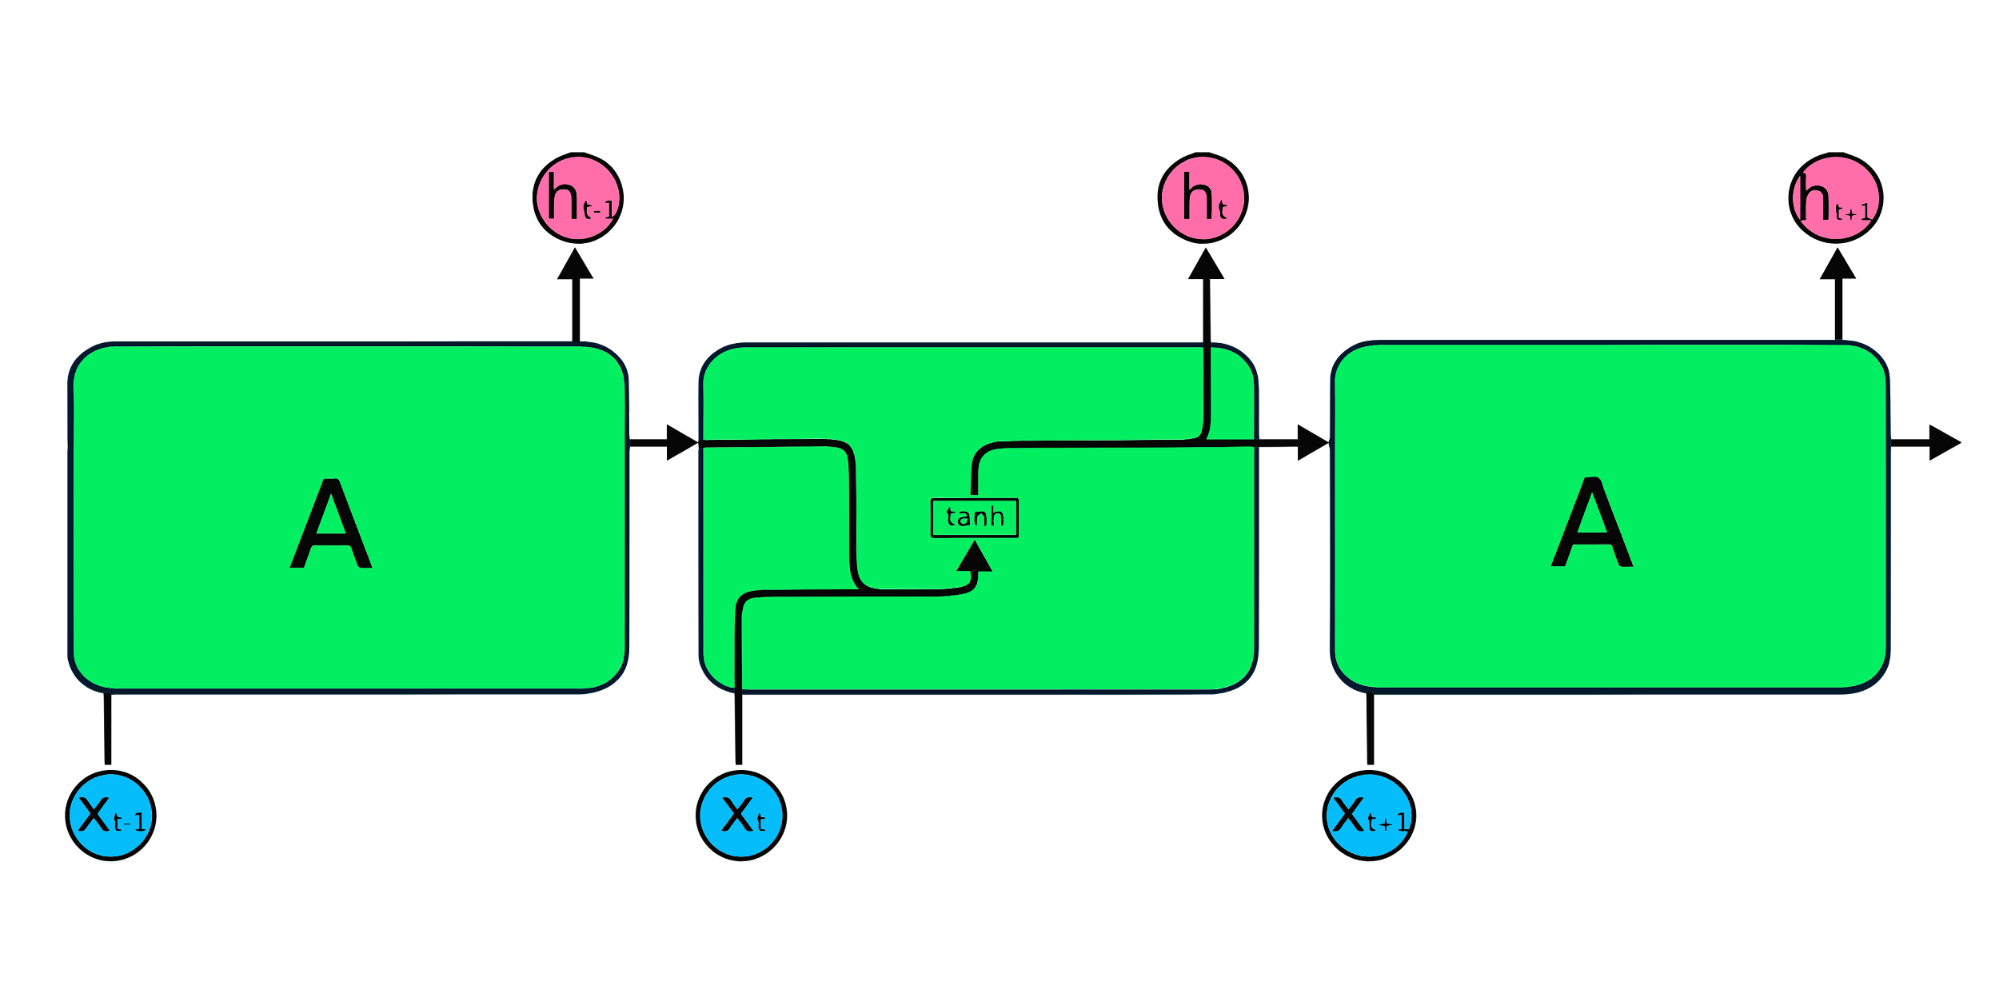

##### Building the RNN model


In [22]:
# Embedding layer takes several char indices sequences (batch) as an input.
# It encodes every character of every sequence to a vector of tmp_embeding_size length.

def rnn_model(vocab_size, batch_size):
  model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, 256,
                        batch_input_shape=[batch_size, None]),
  tf.keras.layers.SimpleRNN(1024, 
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [23]:
model_rnn = rnn_model(vocab_size,BATCH_SIZE)

##### compiling

In [24]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_rnn.compile(
optimizer=adam_optimizer,
  loss=loss,
  metrics=['accuracy']
)


##### configuring Checkpoints

In [25]:
# directory where checkpoints will be saved
checkpoint_dir = 'checkpoints/rnn'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix, monitor='accuracy',
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    mode='max')

##### RNN fiting

In [ ]:
EPOCHS = 100
history_rnn = model_rnn.fit(train_dataset, epochs=EPOCHS,
                         callbacks=[checkpoint_callback])

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 3.4516 - accuracy: 0.1806
Epoch 1: accuracy improved from -inf to 0.18060, saving model to checkpoints/rnn/ckpt_1
59/59 [==============================] - 31s 428ms/step - loss: 3.4516 - accuracy: 0.1806
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 2.3224 - accuracy: 0.3528
Epoch 2: accuracy improved from 0.18060 to 0.35279, saving model to checkpoints/rnn/ckpt_2
59/59 [==============================] - 10s 176ms/step - loss: 2.3224 - accuracy: 0.3528
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 2.1469 - accuracy: 0.3882
Epoch 3: accuracy improved from 0.35279 to 0.38820, saving model to checkpoints/rnn/ckpt_3
59/59 [==============================] - 10s 176ms/step - loss: 2.1469 - accuracy: 0.3882
Epoch 4/100
59/59 [==============================] - ETA: 0s - loss: 2.0446 - accuracy: 0.4125
Epoch 4: accuracy improved from 0.38820 to 0.41248, saving model to checkpoints/

##### changing the tensorshape for generating the text

In [ ]:
checkpoint_dir = 'checkpoints/rnn'

rnn_model = rnn_model(vocab_size, batch_size=1)

rnn_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

rnn_model.build(tf.TensorShape([1, None]))

##### RNN text generation

In [ ]:
start_string= "Sherlock Holmes"

In [ ]:
generated_text = generate_text(
                    rnn_model, 
                    num_generate = 1000, 
                    temperature = 0.5, 
                    start_string = start_string
                    )

print(generated_text)

Sherlock Holmes, reading the investigation and to confidence of the next one who should be here to ask you think that you have formed me to come back to the too much to someone in the minute and saw a myself about the hall door out with the other side was that also but a struck a man whose all this way, Watson,” said he, glancing at the door of a little particularly,
when I find me ungrateful in the direction and two corner led to you. I could not be such a woman with me.’

“‘Then leave it all
the same security.’

“‘And my son, why, all my marriage, and then closed the direction and gazed the discroping and
informed that you have it out to the house,
which was the bedroom window. It was a very
pretty gipsies in the dark.”

“What also quite so. But there was nothing to deep a cold together. McCarthy’s nervel that his own eyes,
but not many inquiries are several points. He is a cheetah, and there is no sign of a householder to meet up the whole place in sight and rained it, and the other

<br>
<br>
<br>
<br>
<br>

### **LSTM Model** (Long Short Term Memory networks)

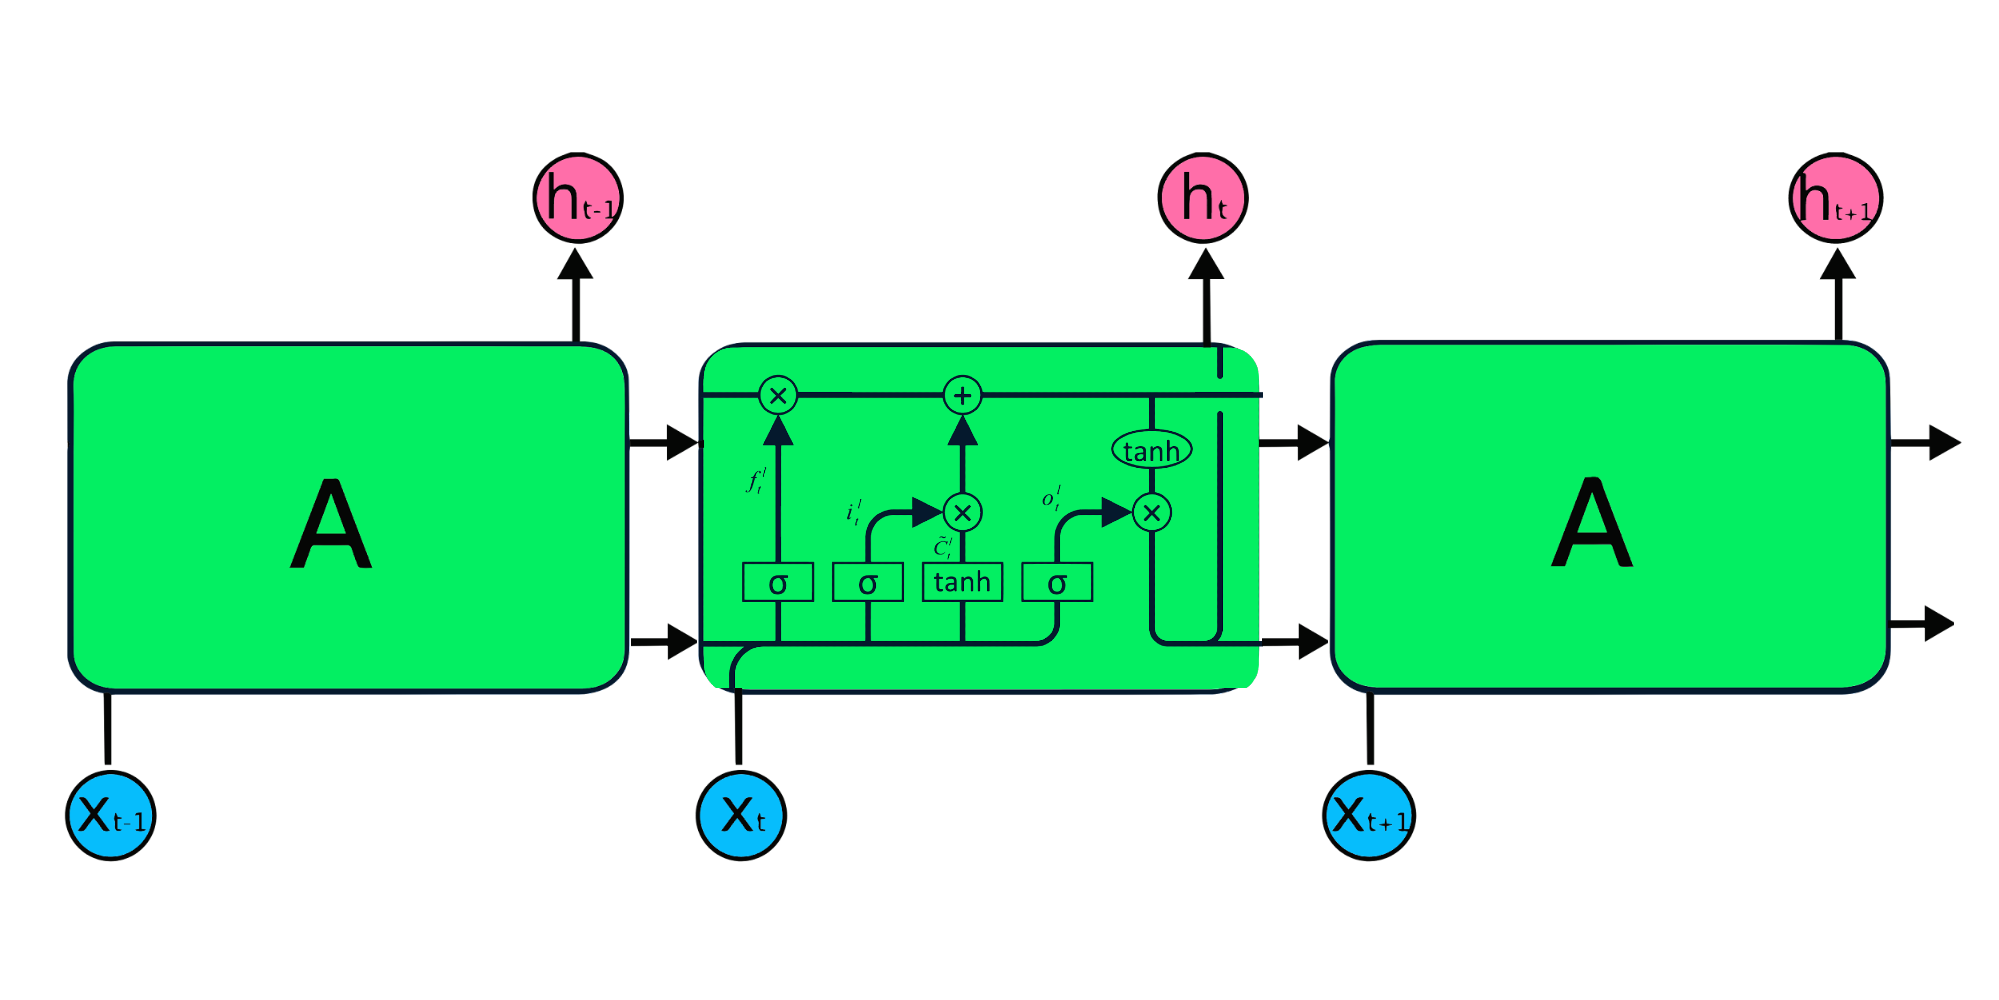

##### Building the LSTM model


In [26]:
def lstm_model(vocab_size, batch_size ):
  model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, 256,
                        batch_input_shape=[batch_size, None]),
  tf.keras.layers.LSTM(1024, 
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
  tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
model_lstm = lstm_model(vocab_size , BATCH_SIZE)

##### compiling

In [ ]:
model_lstm.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy'])

##### configuring Checkpoints

In [ ]:
# directory where checkpoints will be saved
checkpoint_dir = 'checkpoints/lstm'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix, monitor='accuracy',
    verbose=1, 
    save_weights_only=True,
    save_best_only=True,
    mode='max')

Lstm model fitting

In [ ]:
EPOCHS = 100
history_rnn = model_lstm.fit(train_dataset, epochs=EPOCHS,
                         callbacks=[checkpoint_callback])

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 3.0336 - accuracy: 0.2003
Epoch 1: accuracy improved from -inf to 0.20031, saving model to checkpoints/lstm/ckpt_1
59/59 [==============================] - 12s 108ms/step - loss: 3.0336 - accuracy: 0.2003
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 2.3142 - accuracy: 0.3423
Epoch 2: accuracy improved from 0.20031 to 0.34225, saving model to checkpoints/lstm/ckpt_2
59/59 [==============================] - 6s 108ms/step - loss: 2.3142 - accuracy: 0.3423
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 2.0687 - accuracy: 0.4008
Epoch 3: accuracy improved from 0.34225 to 0.40079, saving model to checkpoints/lstm/ckpt_3
59/59 [==============================] - 7s 109ms/step - loss: 2.0687 - accuracy: 0.4008
Epoch 4/100
59/59 [==============================] - ETA: 0s - loss: 1.8811 - accuracy: 0.4506
Epoch 4: accuracy improved from 0.40079 to 0.45064, saving model to checkpoints

##### changing the tensorshape for generating the text

In [ ]:
checkpoint_dir = 'checkpoints/lstm'

lstm_model = lstm_model(vocab_size, batch_size=1)

lstm_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

lstm_model.build(tf.TensorShape([1, None]))

##### LSTM text generation

In [ ]:
start_string= "Sherlock Holmes"

In [ ]:
generated_text = generate_text(
                    lstm_model, 
                    num_generate = 1000, 
                    temperature = 0.5, 
                    start_string = start_string
                    )

print(generated_text)

Sherlock Holmes sat down beside him on the couch and patted him kindly
on the shoulder.

“If you leave, you could make of the matter had been a strong for mental way for the observer of the Chold er and many was attempt the sole in
his hands. He told my companion in the year 1878I I nece Parried away we

“You may safely my hair in Baker?”

“It was a little past six when I arrived, so I went first to have my wound
dressed, and then the doctor was kind enough to bring the last would make a little
manager who has had the very passage in his profession. He has one positive virtuet and fleared the
house that we are particularly so. I have no doubt that she has
only been she had come to a condicion to your way over th.

“Who would be in the years of our favour of a day and action has been deserted, if I am a
widower and he was very kind to me in your had sen
the use of the missing lady. There are rumours of foul play in the
matter, and it amill of during the last signt for some minutes.



R

<br>
<br>
<br>
<br>

### **TRANSFORMERS**

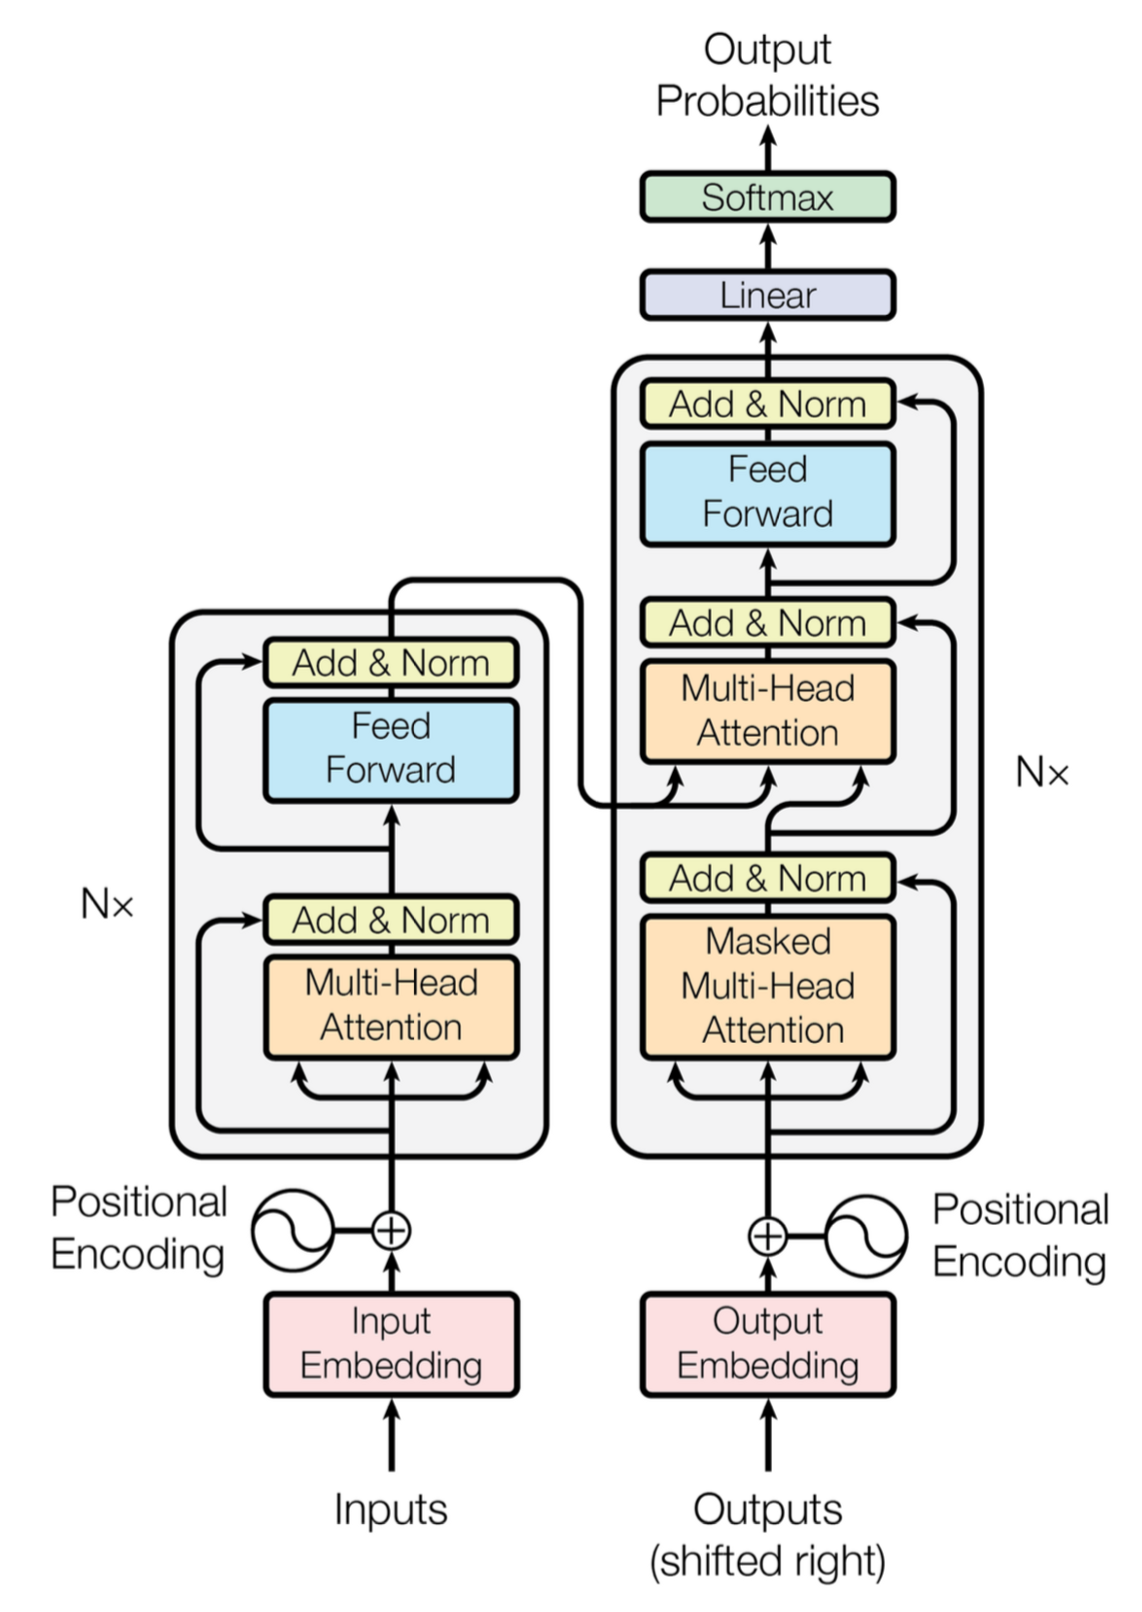

### Finetuned-GPT2 Model

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 5.3 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 52.4 MB/s 
     |████████████████████████████████| 163 kB 75.7 MB/s 


In [ ]:
from transformers import TFGPT2LMHeadModel , GPT2Tokenizer
from tensorflow.python.saved_model.signature_def_utils_impl import predict_signature_def

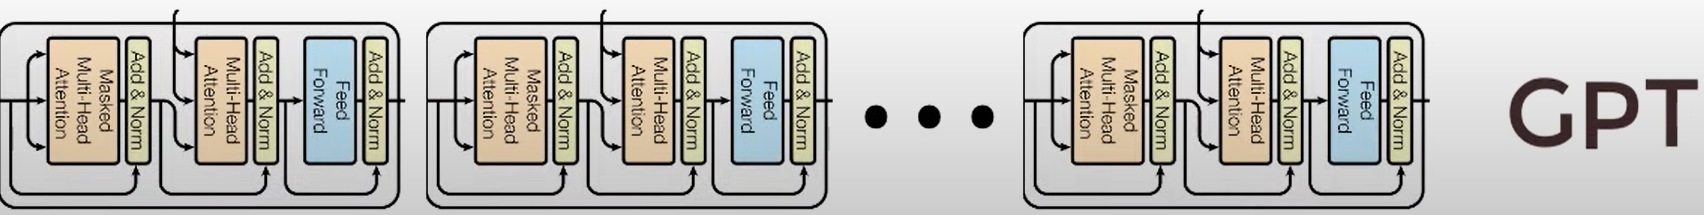

In [ ]:
import string

# loading the pretrained distilled gpt-2 model
model_gpt_fine1 = TFGPT2LMHeadModel.from_pretrained("distilgpt2")
# loading the gpt-2 models tokenizer in tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

# loading the text file for gpt-2
tokenized_text = tokenizer.encode(book)

# tokenizing and creating sequences of 100 words 
examples = []
block_size = 100
for i in range(0, len(tokenized_text) - block_size + 1, block_size):  # Truncate in block of block_size
    examples.append(tokenized_text[i:i + block_size])

# Splitting the data in X, y
inputs, labels = [], []
for ex in examples:
    inputs.append(ex[:-1])
    labels.append(ex[1:])

dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))

BATCH_SIZE = 64

# Defining optimizer as Adam with learning rate of 3e^-5
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Loss Function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# compiling the model
model_gpt_fine1.compile(optimizer=optimizer, loss=[loss, *[None] * model_gpt_fine1.config.n_layer], metrics=[metric])
# model summary
model_gpt_fine1.summary()

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (166629 > 1024). Running this sequence through the model will result in indexing errors


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 81912576  
 r)                                                              
                                                                 
Total params: 81,912,576
Trainable params: 81,912,576
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(dataset, epochs=50)

Epoch 1/50
99/99 [==============================] - 44s 335ms/step - loss: 3.6278 - accuracy: 0.3197
Epoch 2/50
99/99 [==============================] - 34s 344ms/step - loss: 3.3740 - accuracy: 0.3473
Epoch 3/50
99/99 [==============================] - 33s 337ms/step - loss: 3.2428 - accuracy: 0.3610
Epoch 4/50
99/99 [==============================] - 34s 339ms/step - loss: 3.1511 - accuracy: 0.3726
Epoch 5/50
99/99 [==============================] - 34s 341ms/step - loss: 3.0744 - accuracy: 0.3834
Epoch 6/50
99/99 [==============================] - 33s 337ms/step - loss: 3.0092 - accuracy: 0.3914
Epoch 7/50
99/99 [==============================] - 34s 339ms/step - loss: 2.9503 - accuracy: 0.3992
Epoch 8/50
99/99 [==============================] - 34s 338ms/step - loss: 2.8910 - accuracy: 0.4075
Epoch 9/50
99/99 [==============================] - 34s 339ms/step - loss: 2.8382 - accuracy: 0.4145
Epoch 10/50
99/99 [==============================] - 34s 340ms/step - loss: 2.7878 - accura

In [ ]:
model.fit(dataset, epochs=50)

Epoch 1/50
99/99 [==============================] - 34s 338ms/step - loss: 1.2095 - accuracy: 0.6846
Epoch 2/50
99/99 [==============================] - 34s 343ms/step - loss: 1.1829 - accuracy: 0.6916
Epoch 3/50
99/99 [==============================] - 33s 337ms/step - loss: 1.1568 - accuracy: 0.6964
Epoch 4/50
99/99 [==============================] - 34s 339ms/step - loss: 1.1283 - accuracy: 0.7024
Epoch 5/50
99/99 [==============================] - 34s 341ms/step - loss: 1.1038 - accuracy: 0.7071
Epoch 6/50
99/99 [==============================] - 34s 339ms/step - loss: 1.0734 - accuracy: 0.7148
Epoch 7/50
99/99 [==============================] - 34s 341ms/step - loss: 1.0535 - accuracy: 0.7186
Epoch 8/50
99/99 [==============================] - 34s 339ms/step - loss: 1.0306 - accuracy: 0.7241
Epoch 9/50
99/99 [==============================] - 34s 339ms/step - loss: 1.0070 - accuracy: 0.7305
Epoch 10/50
99/99 [==============================] - 34s 339ms/step - loss: 0.9929 - accura

In [ ]:
def generator(input_ids):
  gpt_start = time.time()
  gpt_generate = model.generate(
                                input_ids,
                                do_sample = True, 
                                max_length = MAX_LEN,
                                num_return_sequences = 1
  )


  for i, sample_output in enumerate(gpt_generate):
      print(tokenizer.decode(sample_output, skip_special_tokens = True))
      print('')
  gpt_end = time.time()
  global gpt_time
  gpt_time = gpt_end-gpt_start
  print('\nRun time:', gpt_time)

In [ ]:
MAX_LEN = 150

start_string = 'Oh, Mr. Sherlock Holmes!” she cried'

input_ids = tokenizer.encode(start_string, return_tensors='tf')

In [ ]:
generator(input_ids)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Oh, Mr. Sherlock Holmes!” she cried with all the enthusiasm of a
woman’s laughter. “You see, too, my eyes! I was as
afraid as I was that Flora Millar might have acted in that way when she saw
that my son was in the room.”

“Quite so. She saw it, too. And yet I am convinced that Flora Millar has
seen something very grave in her son. You see, too, my eye! As
a woman who sees an impertinent man do evil deeds in his own home, and who
cannot trust him in any way with his own investigation, and who is absolutely
interested in the investigation of the matter, must ask itself whether he is innocent. Is
the impression of the law to be an excuse for his conduct?”

“I am convinced,” said Holmes, “that it is an excuse.”

The question was clearly and clearly given to the nature of the disturbance, and why the young lady answered
with such a startled glance at the question.

“I am convinced,”
the lady answered, “that the presence of the water was a fact.”

“I perceive that she was not there.”


“Her

### Transformers - Pretrained-GPT2 Model

In [ ]:
#get large GPT2 tokenizer and GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
 
gpt_2_p_model = TFGPT2LMHeadModel.from_pretrained('gpt2-large' ,pad_token_id = tokenizer.eos_token_id)

#view model parameters
gpt_2_p_model.summary()

##### starting string for text generation using transformers

In [ ]:
#maximum number of words in output text
MAX_LEN = 150

start_string = 'Oh, Mr. Sherlock Holmes!” she cried'

input_ids = tokenizer.encode(start_string, return_tensors='tf')

##### text generator funtion for transformers

In [ ]:
def generator(input_ids):
  gpt_start = time.time()
  gpt_generate = gpt_2_p_model.generate(
                                input_ids,
                                do_sample = True, 
                                max_length = MAX_LEN,
                                num_return_sequences = 1
  )


  for i, sample_output in enumerate(gpt_generate):
      print(tokenizer.decode(sample_output, skip_special_tokens = True))
      print('')
  gpt_end = time.time()
  global gpt_time
  gpt_time = gpt_end-gpt_start
  print('\nRun time:', gpt_time)

In [ ]:
generator(input_ids)

0: Oh, Mr. Sherlock Holmes!” she cried.” "You are so stupid.” You can't possibly know what this is all about."”” "Why not?””"” ”I didn't see anything,”” ”the boy replied.”” ”No one will be able to see it,”” ”and I can tell you it isn't real.”

”There was silence for several moments.”” ”The boy raised his voice and said, ”"”I can tell you are a man of science,”” ”and I am a woman of faith,”” ”but I have seen this world and this man before you,”” and they are two very different things."”

The woman said nothing.

”They've been together for six years,” she said. ”They are the closest they've ever been,” ”and if there is anything I can do to help you,” ”I will."”

The man's face fell.”” ”The woman said nothing.

”You cannot save them,” ”the woman continued.” ”You will never find anything in this world that can save them.”...


Run time: 173.38047766685486


#### Time taken for the model to generate the text

Text(0.5, 1.0, 'Time took my models to generate the text')

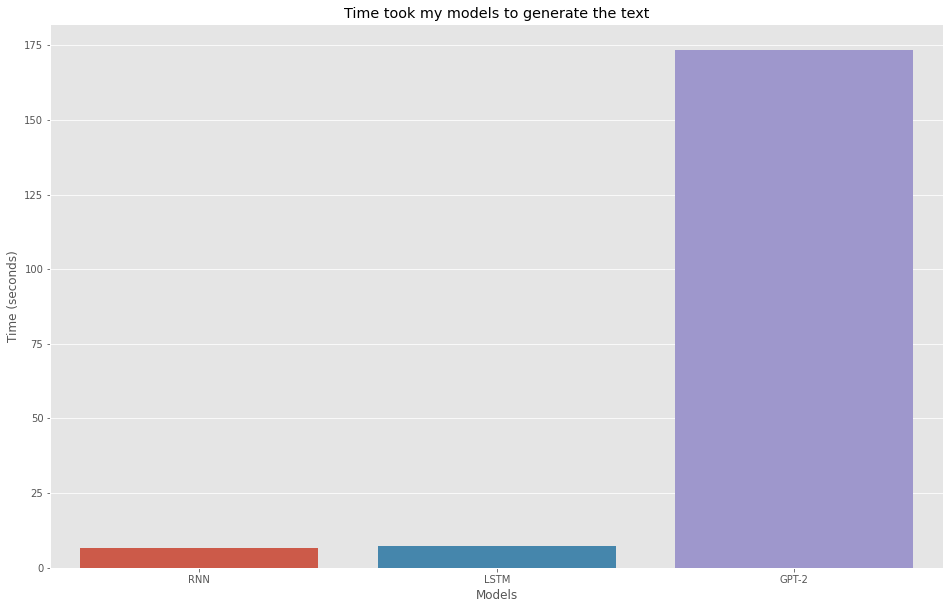

In [ ]:
x=['RNN', 'LSTM', 'GPT-2']
y=[6.5932934284210205,7.424819707870483,173.38047766685486]

fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=x, y=y, ax=ax)
plt.ylabel("Time (seconds)")
plt.xlabel("Models")
plt.title("Time took my models to generate the text")



#### Human readability 

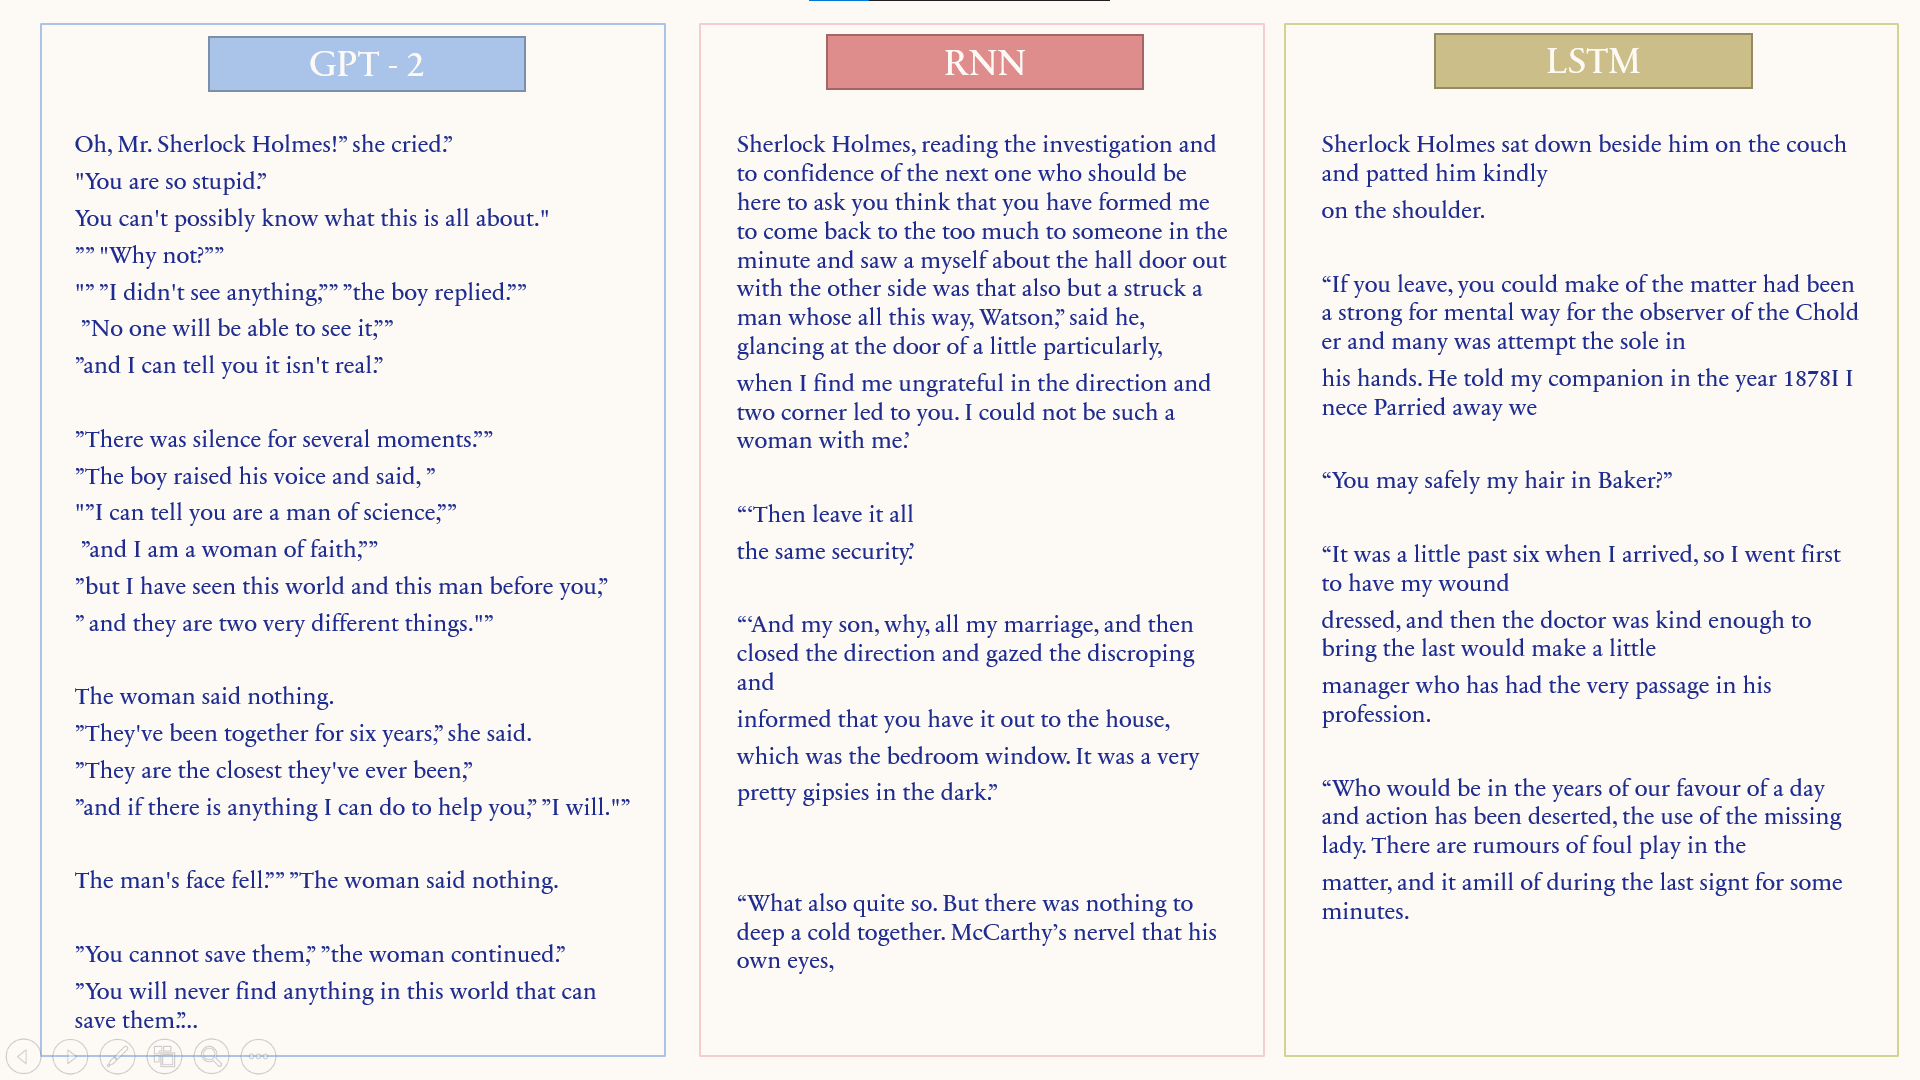

### Serving
Refered document - Tensorflow model serve [rest-simple](https://www.tensorflow.org/tfx/tutorials/serving/rest_simple)

#### Installing tensorflow server

In [ ]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb' -q
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb 

(Reading database ... 123943 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpacking tensorflow-model-server-universal (2.8.0) over (2.8.0) ...
Setting up tensorflow-model-server-universal (2.8.0) ...


In [ ]:
! apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package tensorflow-model-server


#### Saving model to local runtime

In [ ]:
MODEL_DIR = "/model_deploy_using_tfserver"


export_path= MODEL_DIR+"/1"

tf.keras.models.save_model(
    gpt_2_p_model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}


Saved model:
total 18352
drwxr-xr-x 2 root root     4096 Oct 21 14:04 assets
-rw-r--r-- 1 root root   205560 Oct 21 14:04 keras_metadata.pb
-rw-r--r-- 1 root root 18572078 Oct 21 14:04 saved_model.pb
drwxr-xr-x 2 root root     4096 Oct 21 14:04 variables


##### Examining the saved model

In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['attention_mask'] tensor_info:
        dtype: DT_INT64
        shape: (-1, -1)
        name: serving_default_attention_mask:0
    inputs['input_ids'] tensor_info:
        dtype: DT_INT64
        shape: (-1, -1)
        name: serving_default_input_ids:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['logits'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, -1, 50257)
        name: StatefulPartitionedCall:0
    outputs['past_key_values_1'] ten

#### Start running TF serving

##### creating environment variables

In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

##### Straring server (using Bash script)

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=1000 \
  --model_name=predictive_text \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

##### Checking log files

In [ ]:
!tail server.log

2022-10-21 14:14:30.478109: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 257315840 exceeds 10% of free system memory.
2022-10-21 14:14:30.565684: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19660800 exceeds 10% of free system memory.
2022-10-21 14:14:30.899729: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 26214400 exceeds 10% of free system memory.
2022-10-21 14:14:31.172294: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 26214400 exceeds 10% of free system memory.
2022-10-21 14:14:31.473432: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 19660800 exceeds 10% of free system memory.


In [ ]:
def gpt2_servering(start_string):
  input_ids = tokenizer.encode(start_string, return_tensors='tf')
  generator(input_ids)


##### Creating a json for rest api

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": input_ids.numpy().tolist()})
print('Data: ',data)

Data:  {"signature_name": "serving_default", "instances": [[5812, 11, 1770, 13, 25730, 17628, 0, 447, 251, 673, 16896]]}


#### Make REST requests

In [ ]:
!pip install -q requests

##### Getting predection

In [ ]:
import requests

headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:1000/v1/models/predictive_text:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)


In [ ]:
gpt2_servering(predictions)

Output:
----------------------------------------------------------------------------------------------------
0: Oh, Mr. Sherlock Holmes!” she cried, and looked up into his eyes. ”It's all right, my darling,” he said, and looked down at her. ”I'm sorry, love.”

But she didn't say anything. She had no choice but to go along with this. He'd had the last laugh. He was going to see his future in the face of the woman who had tried to kill him.”

"”I've always wondered why you and the others kept away from me so long, when I was just as much of a fool as you.”"

Sherlock laughed again, his voice low and raspy. ”You're not the only one, my love.”

"I am. I know that." ”There was a pause, and then Sherlock took off at a run.” ”I'm going to find my father, and I'm going to find my grandfather.”

They both went their separate ways, but it seemed a little strange to see Sherlock run from her so fast. ”I'm not going to go with you, though, are I?”

"I think you are," she said, and took a couple of

<br>
<br>
<br>

# THANK YOU :)